In [ ]:
#First I import all libraries I will use here
from os.path import exists
from os import listdir
from google.colab import drive
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import torch
from transformers import BertTokenizer
from transformers import DistilBertTokenizer
from transformers import DistilBertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

In [ ]:
#Mount the Google Drive at /content/drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = '/content/drive/MyDrive/BBCNews/BBC News Summary/News Articles' # This is the path to the News_Articles folder
categories = ['business', 'entertainment', 'politics', 'sport', 'tech'] # Here I define the categories, each one corresponding to folder names)
data = [] # Now I initialize a list to hold the data

for category in categories: #For iterator through each category folder
    category_path = os.path.join(path, category)
    for filename in os.listdir(category_path): #Loop through each file in the folder
        if filename.endswith('.txt'): #Just for checking to process al txt files
            file_path = os.path.join(category_path, filename)

            with open(file_path, 'r', encoding='unicode_escape') as file: #Now I ppen and read the file
                text = file.read()
            data.append((text, category)) #Then I append the text and label to the data list

df = pd.DataFrame(data, columns=['text', 'label']) #Now I need to create a DataFrame from the data

# Display the first few rows of the DataFrame
print(df.head())

                                                text     label
0  Rover deal 'may cost 2,000 jobs'\n\nSome 2,000...  business
1  Air passengers win new EU rights\n\nAir passen...  business
2  EU aiming to fuel development aid\n\nEuropean ...  business
3  Yukos unit buyer faces loan claim\n\nThe owner...  business
4  Ethiopia's crop production up 24%\n\nEthiopia ...  business


In [ ]:
def remove_ns(text): #I make quick function to removing the '\n' from the news articles
    return text.replace("\n", " ")

df['text'] = df['text'].apply(remove_ns) #Now I apply this to the DataFrame

In [ ]:
#This is a function to preprocess text
def preprocess_text(text):
    text = text.lower() #I convert text to lowercase
    text = re.sub(r'\d+', '', text) #Now I remove digits
    return text

df['text'] = df['text'].apply(preprocess_text) # Apply preprocessing to the 'text' column
print(df.head()) #Just to make sure I print DataFrame


                                                text     label
0  rover deal 'may cost , jobs'  some , jobs at m...  business
1  air passengers win new eu rights  air passenge...  business
2  eu aiming to fuel development aid  european un...  business
3  yukos unit buyer faces loan claim  the owners ...  business
4  ethiopia's crop production up %  ethiopia prod...  business


In [ ]:
df['text_length_new'] = df['text'].str.split().apply(len) #I create a new column which stores the length of the news articles
print("No. of articles with greater length than DistilBERT max context size: ", len(df[df['text_length_new']>=512])) #Checking out if there is anyone that has more DistilBERT max content

No. of articles with greater length than DistilBERT max context size:  419


In [ ]:
#Now I split the data into training and testing sets (80/20 split as its a very common rule)
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.2, random_state=42,stratify=df['label'],shuffle=True)

#Just to check I display the shapes of the resulting sets
print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

Training set shape: (1780,) (1780,)
Testing set shape: (445,) (445,)


In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased') #Now I initialize the DistilBERT tokenizer

def tokenize_function(text): #This function is to tokenize input text, applying padding and truncation to ensure all token sequences are the same length
    return tokenizer(text, padding='max_length', truncation=True, max_length=512, return_tensors='pt') #Output is in  PyTorch tensor format

X_train_tokens = X_train.apply(tokenize_function) #Apply the function to both training and test sets
X_test_tokens = X_test.apply(tokenize_function)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=5) # Load DistilBERT model
optimizer = AdamW(model.parameters(), lr=2e-5) #Create optimizer with a fixed learning rate

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
def prepare_input(data_tokens): #This function takes a list of tokenized data and concatenates the input_ids and attention_mask into single tensors, preparing them for input to the model.
    input_ids = torch.cat([item['input_ids'] for item in data_tokens], dim=0)
    attention_mask = torch.cat([item['attention_mask'] for item in data_tokens], dim=0)
    return input_ids, attention_mask

train_input_ids, train_attention_mask = prepare_input(X_train_tokens) #Now I create the input tensors for training and test sets
test_input_ids, test_attention_mask = prepare_input(X_test_tokens)

label_encoder = LabelEncoder() #Convert labels to tensors
y_train_encoded = torch.tensor(label_encoder.fit_transform(y_train))
y_test_encoded = torch.tensor(label_encoder.transform(y_test))


In [ ]:
train_dataset = TensorDataset(train_input_ids, train_attention_mask, y_train_encoded) #I create TensorDatasets and DataLoaders for the training, enabling efficient batching of data during training.
train_dataloader = DataLoader(train_dataset, batch_size=6)

test_dataset = TensorDataset(test_input_ids, test_attention_mask, y_test_encoded) #I create a TensorDatasets and DataLoaders for the test set
test_dataloader = DataLoader(test_dataset, batch_size=8)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #Say to the code to use GPU if it founds one
model.to(device)

#I define two lists to store the loss and accuracy values for each epoch
train_loss_values = []
train_accuracy_values = []
epochs = 10  #Put a number of epochs to train
model.train()  #Set model to training mode

for epoch in range(epochs): #This for loop is for each epoch
    print(f'Epoch {epoch+1}/{epochs}')
    epoch_loss = 0  #The idea is to store cumulative loss for the epoch
    epoch_accuracy = 0  #The idea is to store cumulative accuracy for the epoch
    total_preds = []
    total_labels = []

    for batch in train_dataloader: #Iteration on each batch contains a set of samples that will be processed in one go
        #This is to unpack input data, attention masks, and labels
        b_input_ids, b_attention_mask, b_labels = tuple(t.to(device) for t in batch) #The .to(device) method moves the data to the appropriate device (CPU or GPU) for efficiency

        #This line clears any gradients that were previously calculated from the last iteration to avoid interference
        model.zero_grad()

        #Now the model processes the input data and computes the outputs. The labels argument is provided so that the model can calculate the loss based on the true labels during training
        outputs = model(b_input_ids, attention_mask=b_attention_mask, labels=b_labels)
        loss = outputs.loss #Here the loss, how well the model performed on the training data, and logits, raw scores before applying softmax, are extracted from the outputs object
        logits = outputs.logits
        #This line computes the gradient of the loss with respect to the model parameters
        loss.backward() #The .backward() method propagates the gradients backward through the network, allowing the optimizer to know how to adjust the weights to minimize the loss
        optimizer.step() #After computing the gradients, this line updates the model's weights based on the optimize. This is where the model learns by making adjustments to its parameters.
        epoch_loss += loss.item() #This is to accumulate the batch loss
        preds = torch.argmax(logits, dim=1) #Now I calculate the predicted class for each input by finding the index of the maximum logit score along the specified dimension
        total_preds.extend(preds.detach().cpu().numpy()) #Now the true labels are moved to CPU, converted to numpy arrays, and stored in the total_labels list for calculating accuracy later.
        total_labels.extend(b_labels.cpu().numpy())

    #This is the calculation of accuracy for the epoch
    accuracy = accuracy_score(total_labels, total_preds)

    #So finally I store the average loss and accuracy for this epoch
    avg_loss = epoch_loss / len(train_dataloader)
    train_loss_values.append(avg_loss)
    train_accuracy_values.append(accuracy)

    #Print epoch statistics to see how this model is performing
    print(f'Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')


Epoch 1/10
Epoch 1/10 - Loss: 0.3604, Accuracy: 0.9135
Epoch 2/10
Epoch 2/10 - Loss: 0.0466, Accuracy: 0.9882
Epoch 3/10
Epoch 3/10 - Loss: 0.0415, Accuracy: 0.9921
Epoch 4/10
Epoch 4/10 - Loss: 0.0307, Accuracy: 0.9938
Epoch 5/10
Epoch 5/10 - Loss: 0.0105, Accuracy: 0.9983
Epoch 6/10
Epoch 6/10 - Loss: 0.0046, Accuracy: 0.9994
Epoch 7/10
Epoch 7/10 - Loss: 0.0027, Accuracy: 0.9994
Epoch 8/10
Epoch 8/10 - Loss: 0.0156, Accuracy: 0.9961
Epoch 9/10
Epoch 9/10 - Loss: 0.0086, Accuracy: 0.9983
Epoch 10/10
Epoch 10/10 - Loss: 0.0160, Accuracy: 0.9955


In [ ]:
# Define the directory where you want to save the model and tokenizer
save_directory = '/content/drive/MyDrive/BBCNews/BBC News Summary/'

# Save the model and tokenizer
model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)

('/content/drive/MyDrive/BBCNews/BBC News Summary/tokenizer_config.json',
 '/content/drive/MyDrive/BBCNews/BBC News Summary/special_tokens_map.json',
 '/content/drive/MyDrive/BBCNews/BBC News Summary/vocab.txt',
 '/content/drive/MyDrive/BBCNews/BBC News Summary/added_tokens.json')

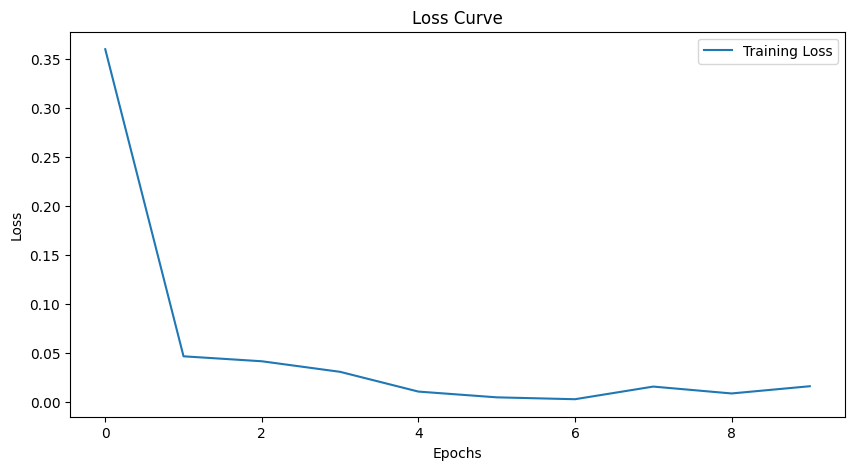

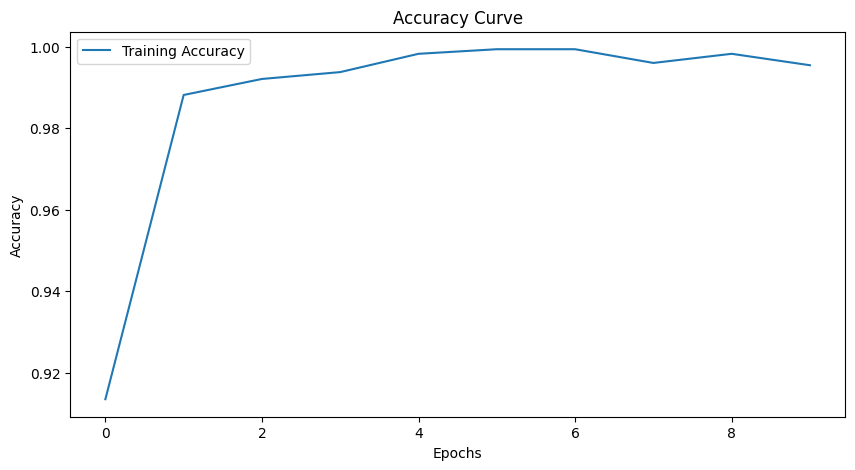

<Figure size 800x800 with 0 Axes>

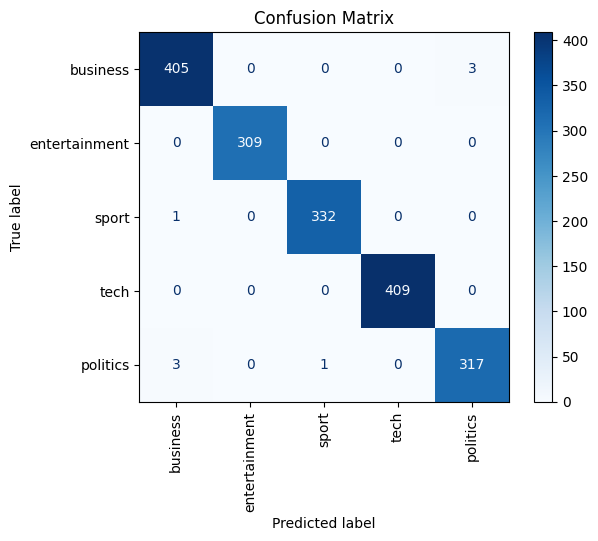

In [ ]:
#First I plot the training training loss curve
plt.figure(figsize=(10,5))
plt.plot(train_loss_values, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()

#Secondly I plot the training accuracy curve
plt.figure(figsize=(10,5))
plt.plot(train_accuracy_values, label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()
plt.show()

#I create the confussion matrix of training dataset
conf_matrix = confusion_matrix(total_labels, total_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,display_labels=categories)
categories = ['business', 'entertainment', 'politics', 'sport', 'tech'] #I define your category labels for CM plot

#Finally I plot the confussion matrix on the training dataset
plt.figure(figsize=(8, 8))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.xticks(rotation=90)
plt.show()


In [ ]:
#For this section I set the model to evaluation mode, this disables dropout and other training-specific layers
model.eval()

#Now I create lists to store predictions and true labels for test data
test_preds = []
test_labels = []

#So I can evaluate the model on the test set
with torch.no_grad(): #As this is testing data, I must disable gradient tracking.
    for batch in test_dataloader: #This line starts a loop that goes through each batch in the test_dataloader, similar to how we processed batches during training.
        b_input_ids, b_attention_mask, b_labels = tuple(t.to(device) for t in batch) #Now I unpack the batch into b_input_ids, b_attention_mask, and b_labels. Alters appropialty between CPU and GPU
        outputs = model(b_input_ids, attention_mask=b_attention_mask) #This line runs a forward pass through the model using the test data. It only returns logits
        logits = outputs.logits #So the raw output scores, logits, are extracted from the outputs. These logits represent the model’s confidence scores for each class.
        preds = torch.argmax(logits, dim=1) #This function finds the index of the maximum score along the specified dimension, effectively giving the predicted class for each sample
        test_preds.extend(preds.cpu().numpy()) #Now the predicted classes are moved back to the CPU and converted to a numpy array. These predictions are then extended into the test_preds list, which collects all predictions from the test set
        test_labels.extend(b_labels.cpu().numpy()) #Again, the true labels from the batch are moved to the CPU and converted to a numpy array

#This is to calculate accuracy on the test set
test_accuracy = accuracy_score(test_labels, test_preds)
print(f'Test Accuracy: {test_accuracy:.4f}')

Test Accuracy: 0.9843


<Figure size 800x800 with 0 Axes>

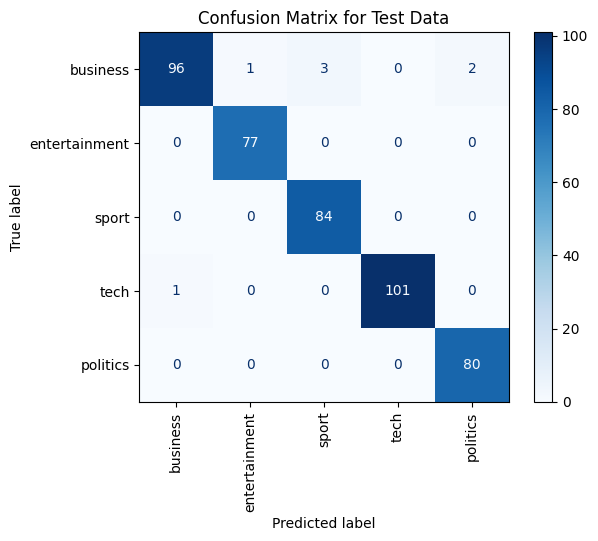

In [ ]:
#I create the confussion matrix of test dataset
conf_matrix = confusion_matrix(test_labels, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,display_labels=categories)

#Finally I plot the confussion matrix on the test dataset
plt.figure(figsize=(8, 8))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Test Data')
plt.xticks(rotation=90)
plt.show()